# Predicting chance of shooting a goal by players

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import math

from matplotlib import pyplot as plt

from utils import create_dummy_df
from utils import run_logistic_regression
from utils import run_lightgbm_classifier

from utils import plot_correlation_matrix
from utils import calculate_confusion_matrix

sns.set()

In [2]:
df_player = pd.read_csv('data/nhl/nhl_stats/game_plays_players.csv')
df_player.drop_duplicates(inplace=True)

In [3]:
df_skater = df_player[df_player.playerType.isin(['Shooter', 'Scorer'])].copy()
df_skater.rename(columns={'player_id':'skater_id'}, inplace=True)
df_skater.drop(columns=['game_id', 'playerType'], inplace=True)

df_goalie = df_player[df_player.playerType.isin(['Goalie'])].copy()
df_goalie.rename(columns={'player_id':'goalie_id'}, inplace=True)
df_goalie.drop(columns=['game_id', 'playerType'], inplace=True)

In [4]:
df_game_plays = pd.read_csv('data/nhl/nhl_stats/game_plays.csv')
df_game_plays.drop_duplicates(inplace=True)

In [5]:
df = df_game_plays.merge(df_skater, how='left', on='play_id')
df = df.merge(df_goalie, how='left', on='play_id')

In [6]:
#df.head()

## Selecting data to be used for the firt model and making it applicable (dropping nan, resolving categorical features)

In [7]:
# select columns, drop nans
df = df[['play_id', 'event', 'secondaryType', 'st_x', 'st_y', 'period', 'periodTime', 'skater_id', 'goalie_id']][(df.event=='Goal') | (df.event=='Shot')]
df.dropna(inplace=True)
df.secondaryType = df.secondaryType.str.replace(" ", "")
df.secondaryType = df.secondaryType.str.replace("-", "")

In [8]:
# prepare target column
df['goal'] = np.where(df.event=='Goal', 1, 0)
df.drop(columns='event', inplace=True)

In [9]:
##################################################

In [10]:
################################################

In [11]:
# categorical data
cat_var_cols = ['secondaryType']
df = create_dummy_df(df=df, cat_cols=cat_var_cols, dummy_na=True)
df.drop(columns=['secondaryType_nan'], inplace=True)

In [12]:
# balance target (goal)
# taking all goals and a sample with the same size from shot without a goal

goals = df[df.goal==1]
no_goals = df[df.goal==0].sample(goals.shape[0], replace=False)
df = pd.concat([goals, no_goals])

In [13]:
# calculating distance from the goal
def dist(df): 
    middle_goal_x = 100 
    middle_goal_y = 0
#    return math.hypot(middle_goal_x - df.st_x, middle_goal_y - df.st_y)
    return math.hypot(middle_goal_x - math.fabs(df.st_x), middle_goal_y - math.fabs(df.st_y))

df['distance'] = df.apply(dist, axis=1)

In [14]:
def angle(df):     
    middle_goal_x = 100 
    return math.fabs(math.degrees(math.atan2(df.st_x - middle_goal_x, df.st_y)) + 90)

df['angle'] = df.apply(angle, axis=1)

<AxesSubplot:>

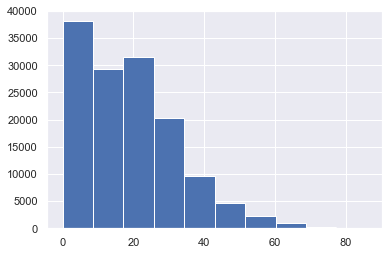

In [15]:
df.angle.hist()

In [16]:
df = df[df.angle<60]

<AxesSubplot:>

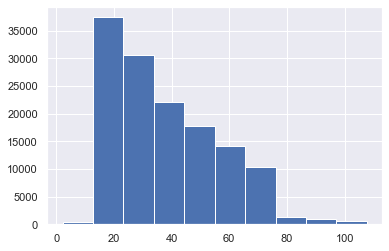

In [17]:
df.distance.hist()

In [18]:
df = df[df.distance<80]

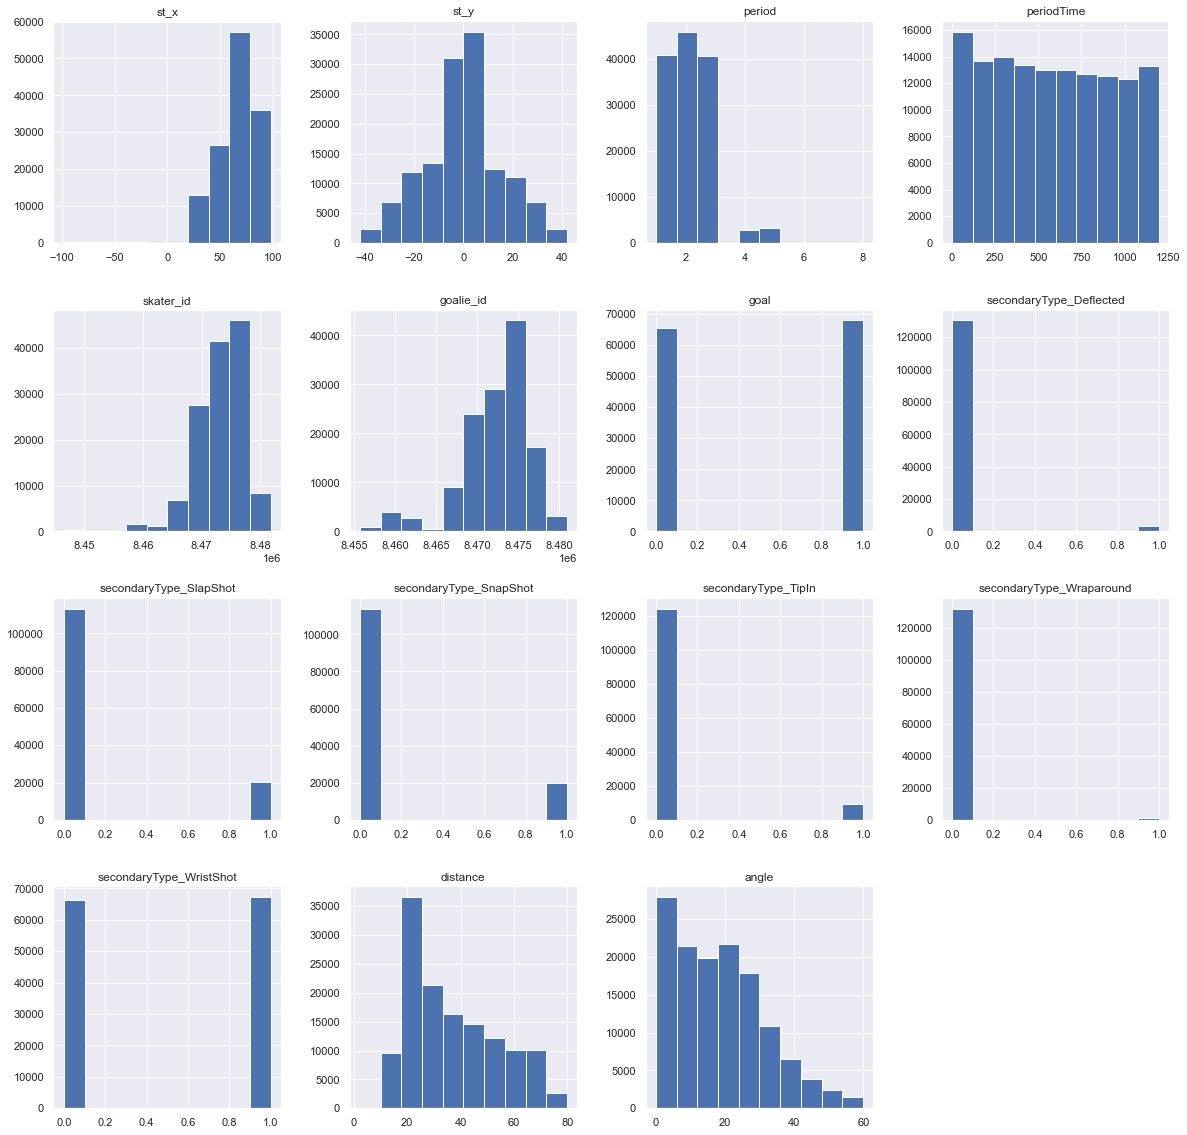

In [19]:
df.hist(figsize=(20, 20));

## Using this features in the first version of the model with no feature engineering yet.

In [20]:
df.columns

Index(['play_id', 'st_x', 'st_y', 'period', 'periodTime', 'skater_id',
       'goalie_id', 'goal', 'secondaryType_Deflected',
       'secondaryType_SlapShot', 'secondaryType_SnapShot',
       'secondaryType_TipIn', 'secondaryType_Wraparound',
       'secondaryType_WristShot', 'distance', 'angle'],
      dtype='object')

In [21]:
features = ['st_x', 'st_y', 'period', 'periodTime', 'secondaryType_Deflected',
       'secondaryType_SlapShot', 'secondaryType_SnapShot',
       'secondaryType_TipIn', 'secondaryType_Wraparound',
       'secondaryType_WristShot', 'distance', 'angle', 'skater_id', 'goalie_id']

#features = ['distance']

target = 'goal'

In [22]:
# function implemented in the utils.py
model, X_test, y_test  = run_logistic_regression(df, features, target)

Training ran in 0.05481 seconds
Score: 0.5107189151460764
F1 Score: 0.68


In [23]:
# function implemented in the utils.py
model, X_test, y_test = run_lightgbm_classifier(df, features, target)

Training ran in 0.24504 seconds
Score: 0.6838418586100309
F1 Score: 0.71


F1 Score: 0.71


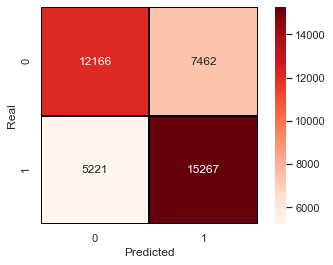

In [24]:
calculate_confusion_matrix(y_test, model.predict(X_test), plot=True);

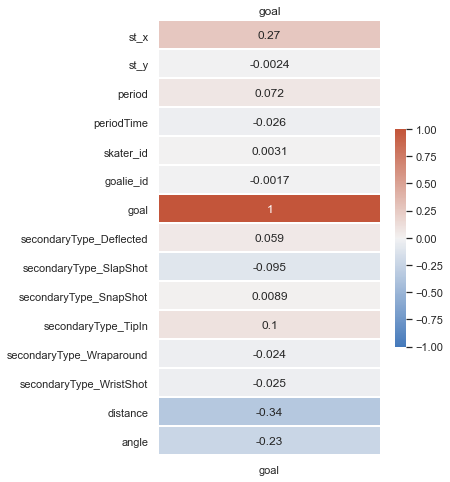

In [25]:
plot_correlation_matrix(df, 'goal')

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from utils import run_model

In [27]:
knn = KNeighborsClassifier(n_neighbors = 100)
_ = run_model(knn, df, features, target)

Training ran in 0.09342 seconds
Score: 0.5194436135207897
F1 Score: 0.54


In [28]:
features = ['distance']

target = 'goal'
model, X_test, y_test = run_logistic_regression(df, features, target)

Training ran in 0.07254 seconds
Score: 0.6564712334230731
F1 Score: 0.68


In [29]:
model.coef_

array([[-0.04470493]])

In [30]:
model.intercept_

array([1.67809327])

In [31]:
df.distance.min()

2.23606797749979

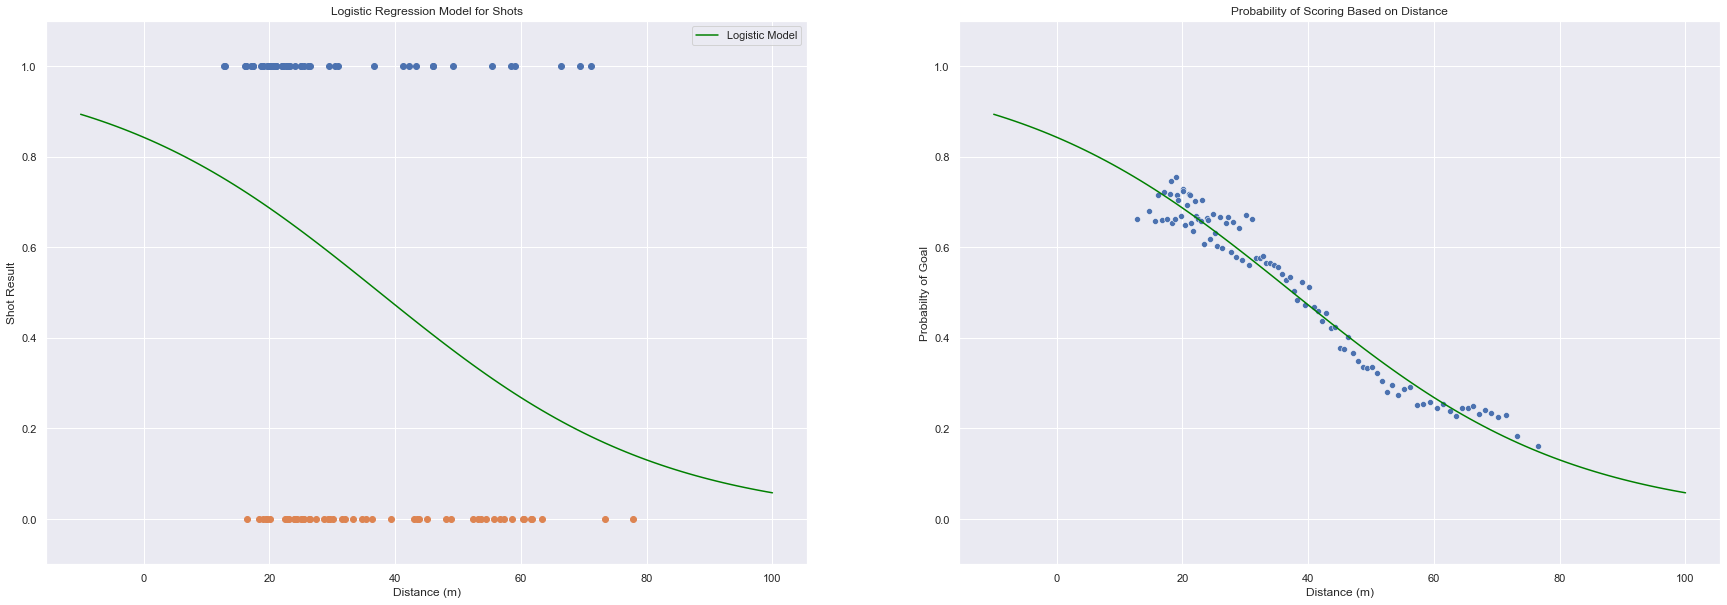

In [32]:
#compare this model to the sample data from before
df_goals = df[df.goal==1]
df_misses = df[df.goal==0]

plt.subplots(1, 2, figsize=(30, 10))
plt.subplot(121)
#goals = plt.scatter(df_log_goal['Distance'].head(100),df_log_goal['Goal'].head(100))
#misses = plt.scatter(df_log_miss['Distance'].head(100),df_log_miss['Goal'].head(100),marker='x')
plt.scatter(df_goals.distance.head(50),df_goals.goal.head(50))
plt.scatter(df_misses.distance.head(50),df_misses.goal.head(50))
y = np.linspace(-10,100,100)

plt.plot(y,1/(1+np.exp(-(model.coef_[0][0]*y+model.intercept_[0]))),c='Green',label='Logistic Model')
#plt.plot(y,1/(1+np.exp(+(.5*y)-15)),c='grey',label='Logistic Function')

plt.xlabel('Distance (m)')
plt.ylabel('Shot Result')
plt.legend()
plt.title('Logistic Regression Model for Shots')
plt.ylim(-.1, 1.1)
#########################################
plt.subplot(122)

#use the seaborn library to inspect the distribution of the shots by result (goal or no goal) 
#fig, axes = plt.subplots(figsize=(11, 5))
#first we want to create bins to calc our probability
#pandas has a function qcut that evenly distibutes the data 
#into n bins based on a desired column value

###df['Goal']=df['Goal'].astype(int)
df['Distance_Bins'] = pd.qcut(df.distance,q=100)
#now we want to find the mean of the Goal column(our prob density) for each bin
#and the mean of the distance for each bin
dist_prob = df.groupby('Distance_Bins',as_index=False)['goal'].mean()['goal']
dist_mean = df.groupby('Distance_Bins',as_index=False)['distance'].mean()['distance']
dist_trend = sns.scatterplot(x=dist_mean,y=dist_prob)
dist_trend.set(xlabel="Distance (m)",
       ylabel="Probabilty of Goal",
       title="Probability of Scoring Based on Distance")
y = np.linspace(-10,100,100)
#sns.lineplot(x = dis,y = 1/(1+np.exp((0.21632621*dis-0.00206089*dis**2-0.58419379))),color='green', label='Log Fit with Quadratic Term')

plt.plot(y,1/(1+np.exp(-(model.coef_[0][0]*y+model.intercept_[0]))),c='Green',label='Logistic Model')
plt.ylim(-.1, 1.1)
plt.show()


In [33]:
df_data_players = df.copy()

# Players

In [34]:
df_player_stats = pd.read_csv('data/nhl/nhl_salaries/train.csv')
df_player_stats.head()

,Salary,Born,City,Pr/St,Cntry,Nat,Ht,Wt,DftYr,DftRd,...,PEND,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS/G
0,925000,97-01-30,Sainte-Marie,QC,CAN,CAN,74,190,2015.0,1.0,...,1.0,0.0,-0.2,-0.2,40.03,1,0.0,175.7,-0.4,-0.38
1,2250000,93-12-21,Ottawa,ON,CAN,CAN,74,207,2012.0,1.0,...,98.0,-0.2,3.4,3.2,2850.59,290,13.3,112.5,14.1,0.18
2,8000000,88-04-16,St. Paul,MN,USA,USA,72,218,2006.0,1.0,...,70.0,3.7,1.3,5.0,2486.75,102,6.6,114.8,36.8,0.57
3,3500000,92-01-07,Ottawa,ON,CAN,CAN,77,220,2010.0,1.0,...,22.0,0.0,0.4,0.5,1074.41,130,17.5,105.1,5.9,0.20
4,1750000,94-03-29,Toronto,ON,CAN,CAN,76,217,2012.0,1.0,...,68.0,-0.1,1.4,1.3,3459.09,425,8.3,99.5,21.8,0.27


In [35]:
df_player_info = pd.read_csv('data/nhl/nhl_stats/player_info.csv')
df_player_info.head()

,player_id,firstName,lastName,nationality,birthCity,primaryPosition,birthDate,birthStateProvince,height,height_cm,weight,shootsCatches
0,8466148,Marian,Hossa,SVK,Stará Lubovna,RW,1979-01-12 00:00:00,NaN,"6' 1""",185.42,207.0,L
1,8465058,Michal,Rozsival,CZE,Vlasim,D,1978-09-03 01:00:00,NaN,"6' 1""",185.42,210.0,R
2,8476906,Shayne,Gostisbehere,USA,Pembroke Pines,D,1993-04-20 01:00:00,FL,"5' 11""",180.34,180.0,L
3,8466285,Brian,Campbell,CAN,Strathroy,D,1979-05-23 01:00:00,ON,"5' 10""",177.80,192.0,L
4,8470607,Brent,Seabrook,CAN,Richmond,D,1985-04-20 01:00:00,BC,"6' 3""",190.50,220.0,R


In [36]:
df_goalie = pd.read_csv('data/nhl/nhl_stats/game_goalie_stats.csv')
df_goalie = df_goalie.groupby('player_id').agg({'savePercentage':'mean'}).reset_index()
df_goalie.rename(columns={'player_id':'goalie_id'}, inplace=True)
df_goalie                                                

,goalie_id,savePercentage
0,8445275,89.979639
1,8445386,89.914678
2,8445470,86.247964
3,8445769,90.347714
4,8446719,87.575872
...,...,...
363,8480263,50.000000
364,8480363,81.818182
365,8480382,90.448332
366,8480420,89.707548


In [37]:
df_skater = pd.read_csv('data/nhl/nhl_stats/game_skater_stats.csv')
df_skater = df_skater.groupby('player_id').agg({'goals':'sum', 'shots':'sum', 'assists':'sum', 'timeOnIce':'sum'}).reset_index()
df_skater.rename(columns={'player_id':'skater_id'}, inplace=True)
df_skater

,skater_id,goals,shots,assists,timeOnIce
0,8444894,11,66,12,51806
1,8444919,4,174,37,232930
2,8445000,88,696,74,322029
3,8445176,59,532,82,214915
4,8445266,7,185,23,329428
...,...,...,...,...,...
3348,8481642,0,2,0,1788
3349,8481649,0,18,0,12652
3350,8481650,4,46,6,43936
3351,8481812,0,0,0,3894


In [38]:
df_merged = df.copy()

df_merged = df_merged.merge(df_skater, how='left', on='skater_id')
df_merged = df_merged.merge(df_goalie, how='left', on='goalie_id')

df_merged

,play_id,st_x,st_y,period,periodTime,skater_id,goalie_id,goal,secondaryType_Deflected,secondaryType_SlapShot,...,secondaryType_Wraparound,secondaryType_WristShot,distance,angle,Distance_Bins,goals,shots,assists,timeOnIce,savePercentage
0,2016020045_6,88.0,-5.0,1,56,8474141.0,8473607.0,1,0,0,...,1,0,13.000000,22.619865,"(2.2350000000000003, 14.0]",505.0,4185.0,815.0,1510638.0,90.093364
1,2016020045_97,76.0,-1.0,1,1046,8477929.0,8473607.0,1,0,0,...,0,0,24.020824,2.385944,"(23.537, 24.021]",10.0,143.0,12.0,89325.0,90.093364
2,2016020045_103,67.0,28.0,1,1092,8478550.0,8473607.0,1,0,1,...,0,0,43.278170,40.314100,"(43.174, 43.932]",224.0,1544.0,413.0,696850.0,90.093364
3,2016020045_140,83.0,-11.0,2,304,8466148.0,8473607.0,1,0,0,...,0,0,20.248457,32.905243,"(20.224, 20.616]",499.0,4143.0,606.0,1429420.0,90.093364
4,2016020045_197,76.0,11.0,2,1103,8476177.0,8470645.0,1,0,0,...,0,1,26.400758,24.623565,"(26.077, 26.571]",94.0,809.0,105.0,476023.0,91.021338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133715,2014020739_191,83.0,14.0,2,935,8469639.0,8470880.0,0,0,0,...,0,0,22.022716,39.472460,"(21.954, 22.091]",138.0,1530.0,210.0,755141.0,90.002935
133716,2013021200_96,52.0,8.0,2,36,8468700.0,8471306.0,0,0,0,...,0,1,48.662100,9.462322,"(48.26, 49.041]",91.0,997.0,145.0,652285.0,90.755161
133717,2012020680_263,55.0,-12.0,3,706,8471769.0,8471239.0,0,0,0,...,0,1,46.572524,14.931417,"(46.065, 46.755]",27.0,833.0,176.0,1223814.0,90.679869
133718,2016030315_6,35.0,-23.0,1,36,8470543.0,8467950.0,0,0,1,...,0,0,68.949257,19.486130,"(68.542, 69.635]",291.0,2384.0,390.0,1114232.0,90.382477


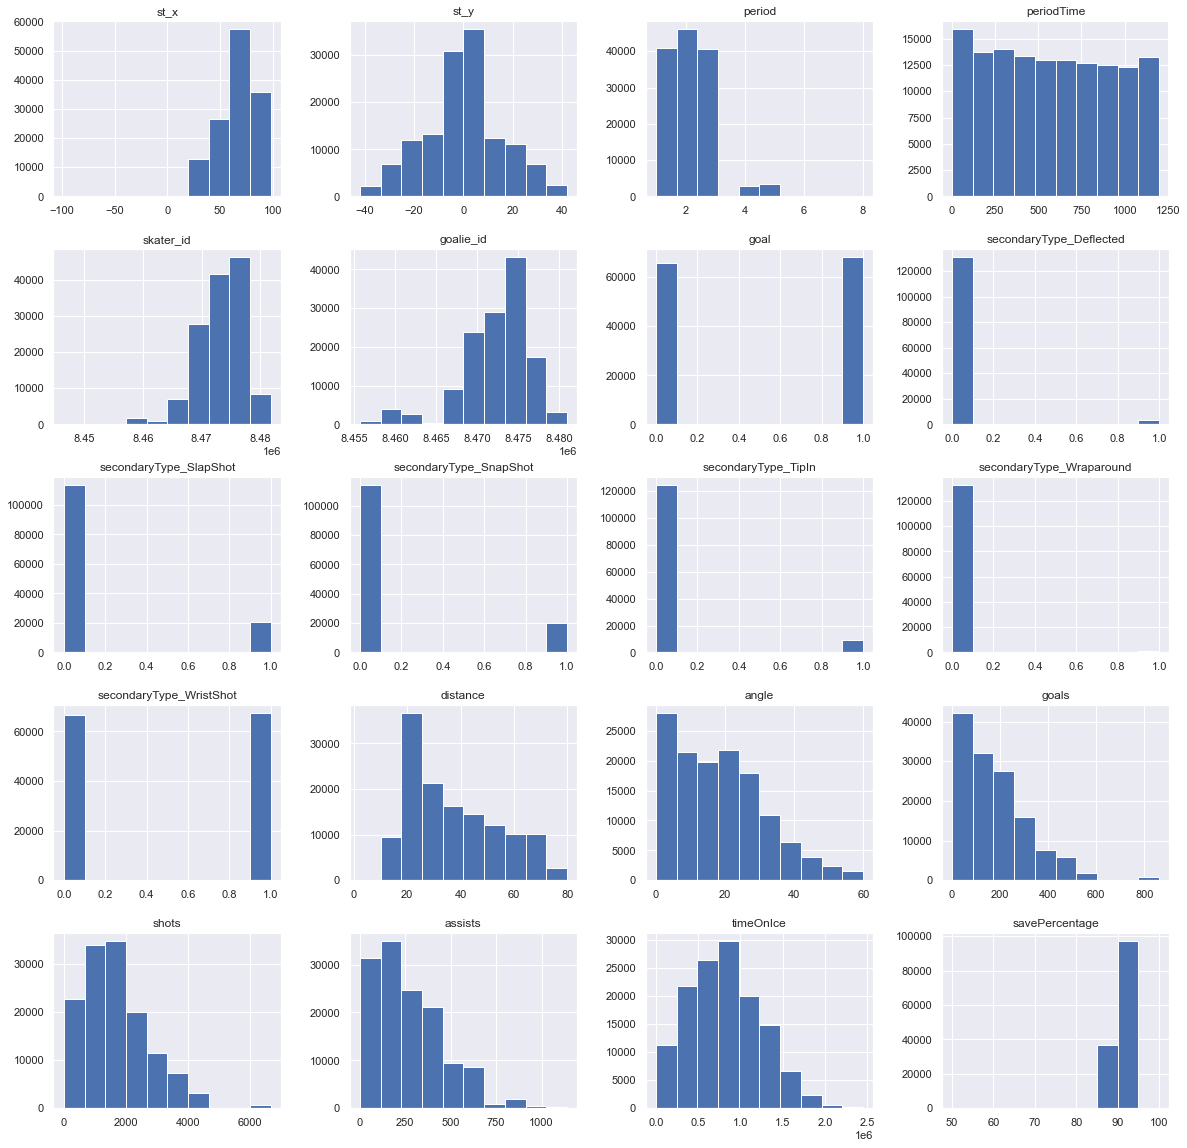

In [39]:
df_merged.hist(figsize=(20, 20));

In [40]:
df_merged = df_merged[df_merged.goals<300]
df_merged = df_merged[df_merged.shots<3000]
df_merged = df_merged[df_merged.assists<500]

df_merged = df_merged[df_merged.distance<30]
df_merged = df_merged[df_merged.angle<30]




In [41]:
df_merged.columns

Index(['play_id', 'st_x', 'st_y', 'period', 'periodTime', 'skater_id',
       'goalie_id', 'goal', 'secondaryType_Deflected',
       'secondaryType_SlapShot', 'secondaryType_SnapShot',
       'secondaryType_TipIn', 'secondaryType_Wraparound',
       'secondaryType_WristShot', 'distance', 'angle', 'Distance_Bins',
       'goals', 'shots', 'assists', 'timeOnIce', 'savePercentage'],
      dtype='object')

In [42]:
from lightgbm import LGBMClassifier

In [43]:
features = ['st_x', 'st_y', 'period', 'periodTime', 'secondaryType_Deflected',
       'secondaryType_SlapShot', 'secondaryType_SnapShot',
       'secondaryType_TipIn', 'secondaryType_Wraparound',
       'secondaryType_WristShot', 'distance', 'angle', 'skater_id', 'goalie_id', 'goals',
       'shots', 'assists', 'timeOnIce', 'savePercentage']


#features = ['secondaryType_Wraparound','angle']


target = 'goal'

# function implemented in the utils.py
model = LGBMClassifier(n_estimators=100,
                     num_leaves=64,
                     max_depth=3,
                     learning_rate=0.1,
                     random_state=1000,
                     eval_metric='auc',
                     n_jobs=-1);



_, X_test, y_test = run_model(model, df_merged, features, target)

[LightGBM] [Warning] Unknown parameter: eval_metric
Training ran in 0.19587 seconds
Score: 0.7002942412778478
F1 Score: 0.82


F1 Score: 0.82


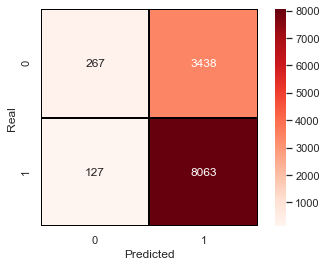

In [44]:
calculate_confusion_matrix(y_test, model.predict(X_test), plot=True);


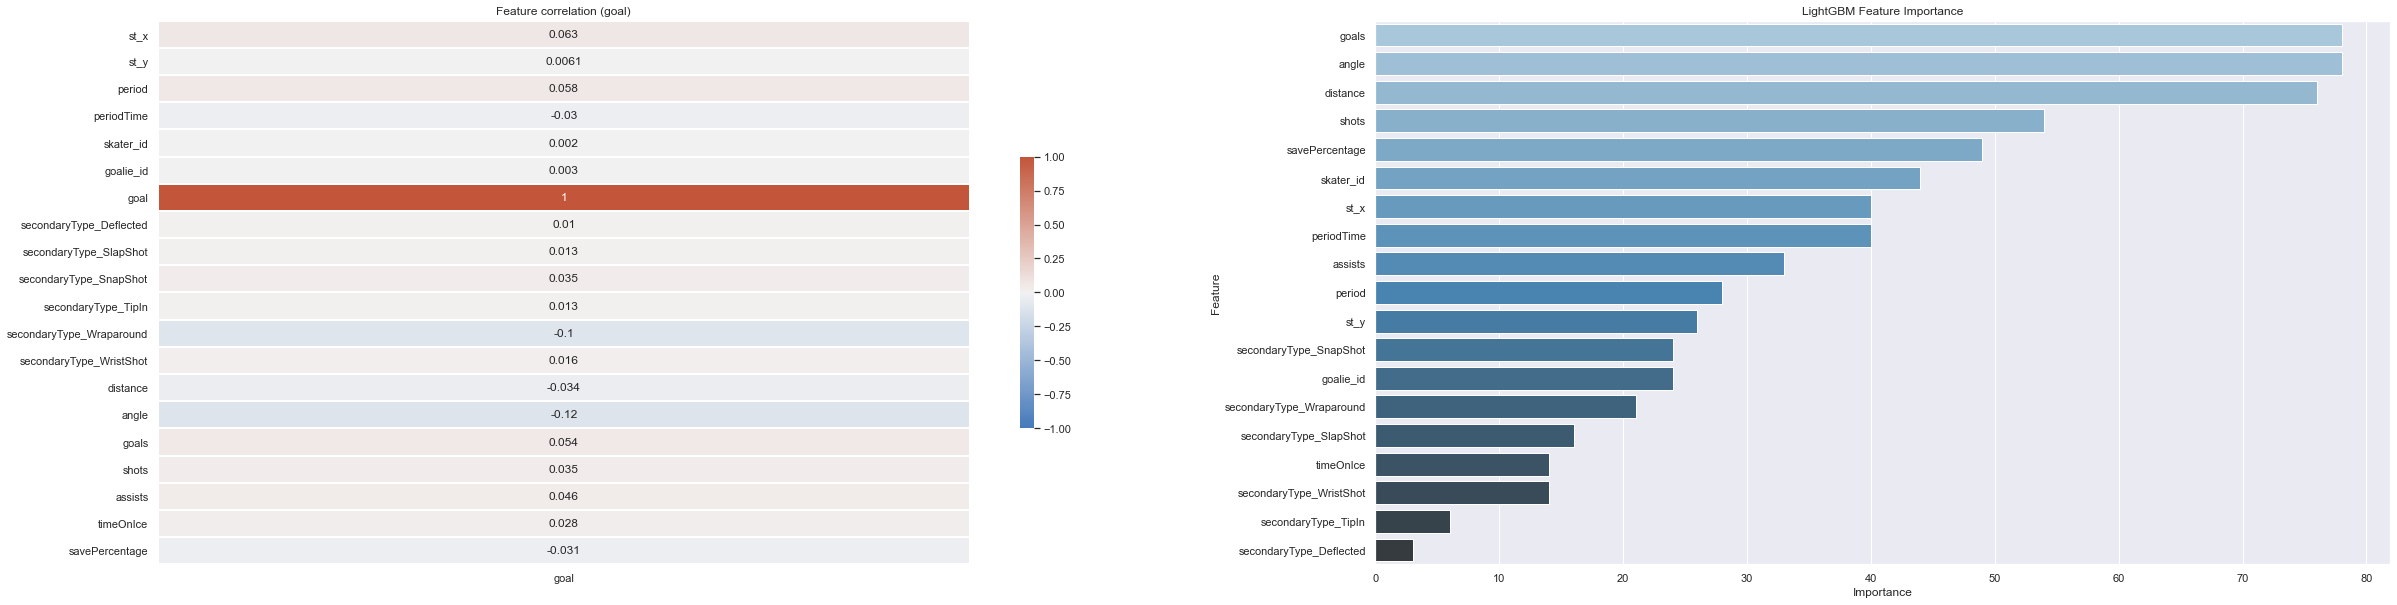

In [45]:
col='goal'
corr = df_merged.corr()
cmap = sns.diverging_palette(250, 20, as_cmap=True)

plt.subplots(1, 2, figsize=(40, 10))
plt.subplot(121)

plt.title('Feature correlation (goal)')
sns.heatmap(corr[[col]], cmap=cmap, vmin=-1, vmax=1, center=0, annot=True, linewidths=1, cbar_kws={"shrink": .5});

plt.subplot(122)
feature_imp = pd.DataFrame({'Importance':model.feature_importances_,'Feature':features})
sns.barplot(x="Importance", y="Feature", palette='Blues_d', data=feature_imp.sort_values(by="Importance", ascending=False))
plt.title('LightGBM Feature Importance')
plt.show()

In [46]:
df_merged

,play_id,st_x,st_y,period,periodTime,skater_id,goalie_id,goal,secondaryType_Deflected,secondaryType_SlapShot,...,secondaryType_Wraparound,secondaryType_WristShot,distance,angle,Distance_Bins,goals,shots,assists,timeOnIce,savePercentage
1,2016020045_97,76.0,-1.0,1,1046,8477929.0,8473607.0,1,0,0,...,0,0,24.020824,2.385944,"(23.537, 24.021]",10.0,143.0,12.0,89325.0,90.093364
4,2016020045_197,76.0,11.0,2,1103,8476177.0,8470645.0,1,0,0,...,0,1,26.400758,24.623565,"(26.077, 26.571]",94.0,809.0,105.0,476023.0,91.021338
5,2016020045_214,79.0,2.0,3,37,8476177.0,8470645.0,1,0,0,...,0,1,21.095023,5.440332,"(21.024, 21.213]",94.0,809.0,105.0,476023.0,91.021338
6,2016020045_219,77.0,-4.0,3,114,8476461.0,8470645.0,1,0,0,...,0,0,23.345235,9.865807,"(23.195, 23.537]",223.0,1876.0,345.0,979356.0,91.021338
7,2016020045_233,85.0,-6.0,3,229,8474190.0,8470645.0,1,0,0,...,0,1,16.155494,21.801409,"(15.811, 16.401]",282.0,2334.0,290.0,1042891.0,91.021338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133703,2019020654_245,79.0,8.0,3,369,8477955.0,8476904.0,0,0,0,...,0,1,22.472205,20.854458,"(22.204, 22.561]",85.0,911.0,111.0,392411.0,94.320764
133706,2010020461_29,84.0,-6.0,1,291,8474068.0,8462047.0,0,0,0,...,0,1,17.088007,20.556045,"(17.0, 17.263]",196.0,1868.0,308.0,931758.0,90.136210
133708,2013020650_228,83.0,-8.0,3,320,8471996.0,8476992.0,0,0,0,...,0,1,18.788294,25.201124,"(18.601, 18.974]",3.0,44.0,3.0,29130.0,87.820867
133712,2010020377_164,82.0,4.0,2,677,8471498.0,8460612.0,0,0,0,...,0,0,18.439089,12.528808,"(18.248, 18.601]",115.0,1068.0,157.0,594705.0,89.954305


In [47]:
df_player_stats = df_player_stats[['First Name', 'Last Name', 'Nat', 'Salary']].rename(columns={'First Name':'firstName', 'Last Name':'lastName', 'Nat':'nationality', 'Salary':'salary'})
df_player_stats

,firstName,lastName,nationality,salary
0,Thomas,Chabot,CAN,925000
1,Cody,Ceci,CAN,2250000
2,Kyle,Okposo,USA,8000000
3,Erik,Gudbranson,CAN,3500000
4,Tom,Wilson,CAN,1750000
...,...,...,...,...
607,Nick,Shore,USA,600000
608,Ryan,Suter,USA,9000000
609,Marc-Edouard,Vlasic,CAN,4250000
610,Tomas,Plekanec,CZE,7000000


In [48]:
df_player_info.rename(columns={'player_id':'skater_id'}, inplace=True)

In [49]:
df_player_info

,skater_id,firstName,lastName,nationality,birthCity,primaryPosition,birthDate,birthStateProvince,height,height_cm,weight,shootsCatches
0,8466148,Marian,Hossa,SVK,Stará Lubovna,RW,1979-01-12 00:00:00,NaN,"6' 1""",185.42,207.0,L
1,8465058,Michal,Rozsival,CZE,Vlasim,D,1978-09-03 01:00:00,NaN,"6' 1""",185.42,210.0,R
2,8476906,Shayne,Gostisbehere,USA,Pembroke Pines,D,1993-04-20 01:00:00,FL,"5' 11""",180.34,180.0,L
3,8466285,Brian,Campbell,CAN,Strathroy,D,1979-05-23 01:00:00,ON,"5' 10""",177.80,192.0,L
4,8470607,Brent,Seabrook,CAN,Richmond,D,1985-04-20 01:00:00,BC,"6' 3""",190.50,220.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...
3920,8479374,Adam,Mascherin,CAN,Maple,LW,1998-06-06 01:00:00,ON,"5' 10""",177.80,205.0,L
3921,8479403,Tyler,Parsons,USA,Mt. Clemas,G,1997-09-18 01:00:00,MI,"6' 1""",185.42,185.0,L
3922,8480970,Marcus,Hogstrom,SWE,Sveg,D,1989-03-20 00:00:00,NaN,"6' 4""",193.04,200.0,L
3923,8477574,Parker,Milner,USA,Pittsburgh,G,1990-09-06 01:00:00,PA,"6' 1""",185.42,185.0,L


In [50]:
#add name and nationality of the skater
df_merged = df_merged.merge(df_player_info[['skater_id', 'firstName', 'lastName', 'nationality']], how='left', on='skater_id')

In [51]:
df_merged

,play_id,st_x,st_y,period,periodTime,skater_id,goalie_id,goal,secondaryType_Deflected,secondaryType_SlapShot,...,angle,Distance_Bins,goals,shots,assists,timeOnIce,savePercentage,firstName,lastName,nationality
0,2016020045_97,76.0,-1.0,1,1046,8477929.0,8473607.0,1,0,0,...,2.385944,"(23.537, 24.021]",10.0,143.0,12.0,89325.0,90.093364,Dennis,Rasmussen,SWE
1,2016020045_197,76.0,11.0,2,1103,8476177.0,8470645.0,1,0,0,...,24.623565,"(26.077, 26.571]",94.0,809.0,105.0,476023.0,91.021338,Matt,Read,CAN
2,2016020045_214,79.0,2.0,3,37,8476177.0,8470645.0,1,0,0,...,5.440332,"(21.024, 21.213]",94.0,809.0,105.0,476023.0,91.021338,Matt,Read,CAN
3,2016020045_219,77.0,-4.0,3,114,8476461.0,8470645.0,1,0,0,...,9.865807,"(23.195, 23.537]",223.0,1876.0,345.0,979356.0,91.021338,Sean,Couturier,CAN
4,2016020045_233,85.0,-6.0,3,229,8474190.0,8470645.0,1,0,0,...,21.801409,"(15.811, 16.401]",282.0,2334.0,290.0,1042891.0,91.021338,Wayne,Simmonds,CAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39644,2019020654_245,79.0,8.0,3,369,8477955.0,8476904.0,0,0,0,...,20.854458,"(22.204, 22.561]",85.0,911.0,111.0,392411.0,94.320764,Jared,McCann,CAN
39645,2010020461_29,84.0,-6.0,1,291,8474068.0,8462047.0,0,0,0,...,20.556045,"(17.0, 17.263]",196.0,1868.0,308.0,931758.0,90.136210,Kyle,Turris,CAN
39646,2013020650_228,83.0,-8.0,3,320,8471996.0,8476992.0,0,0,0,...,25.201124,"(18.601, 18.974]",3.0,44.0,3.0,29130.0,87.820867,Bracken,Kearns,CAN
39647,2010020377_164,82.0,4.0,2,677,8471498.0,8460612.0,0,0,0,...,12.528808,"(18.248, 18.601]",115.0,1068.0,157.0,594705.0,89.954305,Jannik,Hansen,DNK


In [52]:
# add salary
df_merged = df_merged.merge(df_player_stats, how='left', on=['firstName', 'lastName', 'nationality'])

In [53]:
df_merged

,play_id,st_x,st_y,period,periodTime,skater_id,goalie_id,goal,secondaryType_Deflected,secondaryType_SlapShot,...,Distance_Bins,goals,shots,assists,timeOnIce,savePercentage,firstName,lastName,nationality,salary
0,2016020045_97,76.0,-1.0,1,1046,8477929.0,8473607.0,1,0,0,...,"(23.537, 24.021]",10.0,143.0,12.0,89325.0,90.093364,Dennis,Rasmussen,SWE,575000.0
1,2016020045_197,76.0,11.0,2,1103,8476177.0,8470645.0,1,0,0,...,"(26.077, 26.571]",94.0,809.0,105.0,476023.0,91.021338,Matt,Read,CAN,4000000.0
2,2016020045_214,79.0,2.0,3,37,8476177.0,8470645.0,1,0,0,...,"(21.024, 21.213]",94.0,809.0,105.0,476023.0,91.021338,Matt,Read,CAN,4000000.0
3,2016020045_219,77.0,-4.0,3,114,8476461.0,8470645.0,1,0,0,...,"(23.195, 23.537]",223.0,1876.0,345.0,979356.0,91.021338,Sean,Couturier,CAN,3750000.0
4,2016020045_233,85.0,-6.0,3,229,8474190.0,8470645.0,1,0,0,...,"(15.811, 16.401]",282.0,2334.0,290.0,1042891.0,91.021338,Wayne,Simmonds,CAN,4300000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39644,2019020654_245,79.0,8.0,3,369,8477955.0,8476904.0,0,0,0,...,"(22.204, 22.561]",85.0,911.0,111.0,392411.0,94.320764,Jared,McCann,CAN,NaN
39645,2010020461_29,84.0,-6.0,1,291,8474068.0,8462047.0,0,0,0,...,"(17.0, 17.263]",196.0,1868.0,308.0,931758.0,90.136210,Kyle,Turris,CAN,4000000.0
39646,2013020650_228,83.0,-8.0,3,320,8471996.0,8476992.0,0,0,0,...,"(18.601, 18.974]",3.0,44.0,3.0,29130.0,87.820867,Bracken,Kearns,CAN,800000.0
39647,2010020377_164,82.0,4.0,2,677,8471498.0,8460612.0,0,0,0,...,"(18.248, 18.601]",115.0,1068.0,157.0,594705.0,89.954305,Jannik,Hansen,DNK,NaN


In [54]:
# replace missing salary
df_merged.salary.fillna(df_merged.salary.median(), inplace=True)

In [55]:
df_merged.describe()

,st_x,st_y,period,periodTime,skater_id,goalie_id,goal,secondaryType_Deflected,secondaryType_SlapShot,secondaryType_SnapShot,...,secondaryType_Wraparound,secondaryType_WristShot,distance,angle,goals,shots,assists,timeOnIce,savePercentage,salary
count,39649.000000,39649.000000,39649.000000,39649.000000,3.964900e+04,3.964900e+04,39649.000000,39649.000000,39649.000000,39649.000000,...,39649.000000,39649.000000,39649.000000,39649.000000,39649.000000,39649.000000,39649.000000,3.964900e+04,39649.000000,3.964900e+04
mean,78.075790,-0.149764,2.170925,570.400313,8.473987e+06,8.472212e+06,0.686726,0.046786,0.019572,0.091377,...,0.021564,0.486544,21.699054,12.017899,140.384272,1284.711392,194.986153,6.493089e+05,90.328548,2.753492e+06
std,12.717763,5.438158,1.014457,358.176668,3.700073e+03,4.159873e+03,0.463831,0.211182,0.138525,0.288148,...,0.145258,0.499825,3.988681,8.280164,80.165207,646.947278,115.977136,3.120010e+05,0.858145,1.500854e+06
min,-98.000000,-27.000000,1.000000,0.000000,8.446485e+06,8.455710e+06,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.236068,0.000000,0.000000,1.000000,0.000000,7.130000e+02,58.333333,5.750000e+05
25%,76.000000,-4.000000,1.000000,258.000000,8.471323e+06,8.470594e+06,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,18.973666,4.763642,71.000000,786.000000,99.000000,4.335920e+05,89.983858,2.250000e+06
50%,79.000000,0.000000,2.000000,559.000000,8.474709e+06,8.471750e+06,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,21.213203,10.885527,138.000000,1286.000000,189.000000,6.516990e+05,90.382477,2.600000e+06
75%,82.000000,4.000000,3.000000,880.000000,8.476466e+06,8.475311e+06,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,24.738634,18.434949,208.000000,1766.000000,284.000000,8.434930e+05,90.806256,3.000000e+06
max,96.000000,28.000000,6.000000,1200.000000,8.481813e+06,8.480925e+06,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,29.966648,29.744881,298.000000,2850.000000,490.000000,2.108865e+06,98.000000,1.100000e+07


In [56]:
features = df_merged.select_dtypes(exclude='object').columns.to_list()

In [57]:
features.remove('goal')

In [58]:
features = ['st_x', 'st_y', 'period', 'periodTime', 'secondaryType_Deflected',
       'secondaryType_SlapShot', 'secondaryType_SnapShot',
       'secondaryType_TipIn', 'secondaryType_Wraparound',
       'secondaryType_WristShot', 'distance', 'angle', 'skater_id', 'goalie_id', 'goals',
       'shots', 'assists', 'timeOnIce', 'savePercentage', 'salary']

#features = df_merged.select_dtypes(exclude='object').columns.to_list().remove('goal')
#features = ['secondaryType_Wraparound','angle']


target = 'goal'

# function implemented in the utils.py
model = LGBMClassifier(n_estimators=100,
                     num_leaves=64,
                     max_depth=3,
                     learning_rate=0.1,
                     random_state=1000,                     
                     n_jobs=-1);



_, X_test, y_test = run_model(model, df_merged, features, target)

Training ran in 0.19241 seconds
Score: 0.6996216897856242
F1 Score: 0.82


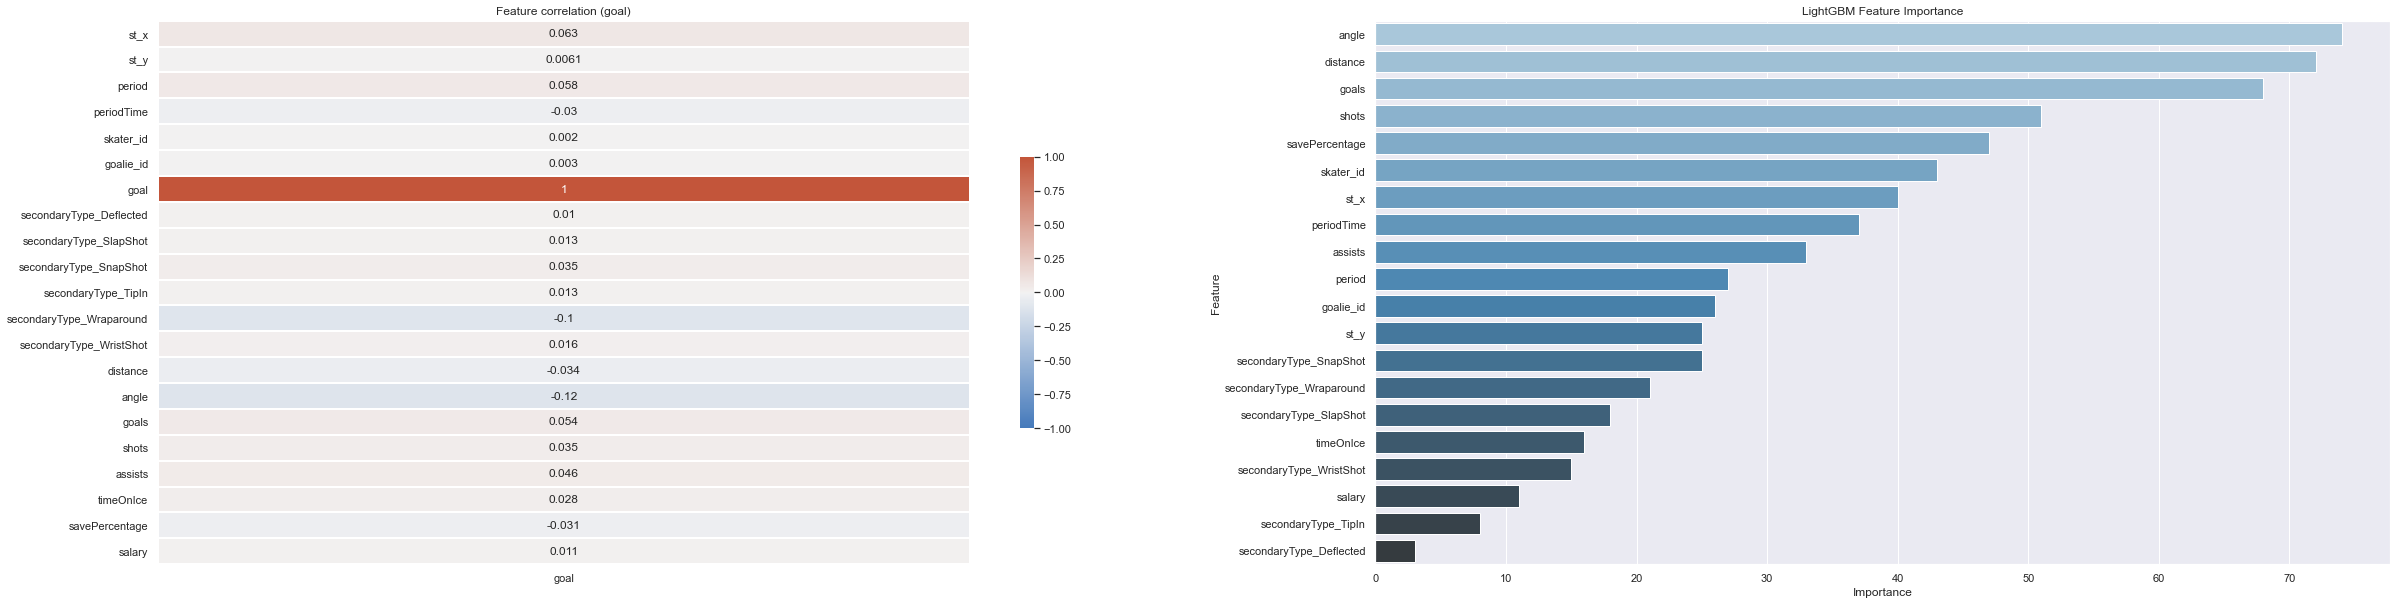

In [59]:
col='goal'
corr = df_merged.corr()
cmap = sns.diverging_palette(250, 20, as_cmap=True)

plt.subplots(1, 2, figsize=(40, 10))
plt.subplot(121)

plt.title('Feature correlation (goal)')
sns.heatmap(corr[[col]], cmap=cmap, vmin=-1, vmax=1, center=0, annot=True, linewidths=1, cbar_kws={"shrink": .5});

plt.subplot(122)
feature_imp = pd.DataFrame({'Importance':model.feature_importances_,'Feature':features})
sns.barplot(x="Importance", y="Feature", palette='Blues_d', data=feature_imp.sort_values(by="Importance", ascending=False))
plt.title('LightGBM Feature Importance')
plt.show()

In [60]:
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

In [62]:
#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(df_merged[features], df_merged[target], test_size=0.3, random_state=42)


# Scores ~0.784 (without tuning and early stopping)
params = {'boosting_type': 'gbdt', 'max_depth': -1, 'objective': 'binary', 
          'num_leaves': 64, 'learning_rate': 0.05, 'max_bin': 512, 
          'subsample_for_bin': 200, 'subsample': 1, 'subsample_freq': 1,
          'colsample_bytree': 0.8, 'reg_alpha': 5, 'reg_lambda': 10, 
          'min_split_gain': 0.5, 'min_child_weight': 1, 
          'min_child_samples': 5, 'scale_pos_weight': 1, 'num_class': 1, 
          'metric': 'binary_error'}

# Create parameters to search
grid_params = {'learning_rate': [0.0001, 0.01, 0.1, 0.15], 
               'n_estimators': [60, 100, 120],
               'num_leaves': [12, 16, 64, 80], 
               'boosting_type': ['gbdt'], 
               'max_depth':[2, 3, 4],
               'objective': ['binary'], 
               'seed': [500],
               'colsample_bytree': [0.65, 0.75, 0.8], 
               'subsample': [0.7, 0.75], 'reg_alpha': [1, 2, 6],
               'reg_lambda': [1, 2, 6]}

model = LGBMClassifier(**params);
grid = GridSearchCV(model, param_grid=grid_params, verbose=1, cv=5, n_jobs=-1)

# start trainig
start = time.time()
print(f'Starting...')

grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)


#model.fit(X_train,y_train)
duration = time.time() - start
print(f'Training ran in {duration:.5f} seconds')    

# use model score
score = grid.score(X_test, y_test)    
print(f'Score: {score}')

#calculate f1 score
f1 = f1_score(y_test, grid.predict(X_test))
print(f'F1 Score: {f1:.2f}')

Starting...
Fitting 5 folds for each of 7776 candidates, totalling 38880 fits
{'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'num_leaves': 12, 'objective': 'binary', 'reg_alpha': 1, 'reg_lambda': 2, 'seed': 500, 'subsample': 0.75}
0.6977732248551921
Training ran in 1098.06102 seconds
Score: 0.6986128625472888
F1 Score: 0.82


In [ ]:
#second iteration

In [63]:
#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(df_merged[features], df_merged[target], test_size=0.3, random_state=42)


# Scores ~0.784 (without tuning and early stopping)
params = {'boosting_type': 'gbdt', 
          'colsample_bytree': 0.8, 
          'learning_rate': 0.1, 
          'max_depth': 4, 
          'n_estimators': 100, 
          'num_leaves': 12, 
          'objective': 'binary', 
          'reg_alpha': 1, 
          'reg_lambda': 2, 
          'seed': 500, 
          'subsample': 0.75}

# Create parameters to search
grid_params = {'boosting_type': ['gbdt'], 
          'colsample_bytree': [0.8, 0.9], 
          'learning_rate': [0.1], 
          'max_depth': [4, 5, 6], 
          'n_estimators': [100], 
          'num_leaves': [6, 12, 18], 
          'objective': ['binary'], 
          'reg_alpha': [0.1, 1, 2], 
          'reg_lambda': [2], 
          'seed': [400, 500, 600], 
          'subsample': [0.75, 0.8, 0.85]}

model = LGBMClassifier(**params);
grid = GridSearchCV(model, param_grid=grid_params, verbose=1, cv=5, n_jobs=-1)

# start trainig
start = time.time()
print(f'Starting...')

grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)


#model.fit(X_train,y_train)
duration = time.time() - start
print(f'Training ran in {duration:.5f} seconds')    

# use model score
score = grid.score(X_test, y_test)    
print(f'Score: {score}')

#calculate f1 score
f1 = f1_score(y_test, grid.predict(X_test))
print(f'F1 Score: {f1:.2f}')

Starting...
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'num_leaves': 18, 'objective': 'binary', 'reg_alpha': 2, 'reg_lambda': 2, 'seed': 600, 'subsample': 0.75}
0.6976290677274284
Training ran in 91.48020 seconds
Score: 0.7005464480874317
F1 Score: 0.82


In [64]:
#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(df_merged[features], df_merged[target], test_size=0.3, random_state=42)


# Scores ~0.784 (without tuning and early stopping)
params = {'boosting_type': 'gbdt', 
          'colsample_bytree': 0.8, 
          'learning_rate': 0.1, 
          'max_depth': 4, 
          'n_estimators': 100, 
          'num_leaves': 12, 
          'objective': 'binary', 
          'reg_alpha': 1, 
          'reg_lambda': 2, 
          'seed': 500, 
          'subsample': 0.75}

# Create parameters to search
grid_params = {'boosting_type': ['gbdt'], 
          'colsample_bytree': [0.8, 0.9], 
          'learning_rate': [0.1], 
          'max_depth': [4, 5, 6], 
          'n_estimators': [100], 
          'num_leaves': [18, 24], 
          'objective': ['binary'], 
          'reg_alpha': [2, 3, 4], 
          'reg_lambda': [2, 3, 4], 
          'seed': [600, 700, 800], 
          'subsample': [0.75]}

model = LGBMClassifier(**params);
grid = GridSearchCV(model, param_grid=grid_params, verbose=1, cv=5, n_jobs=-1)

# start trainig
start = time.time()
print(f'Starting...')

grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)


#model.fit(X_train,y_train)
duration = time.time() - start
print(f'Training ran in {duration:.5f} seconds')    

# use model score
score = grid.score(X_test, y_test)    
print(f'Score: {score}')

#calculate f1 score
f1 = f1_score(y_test, grid.predict(X_test))
print(f'F1 Score: {f1:.2f}')

Starting...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
{'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 18, 'objective': 'binary', 'reg_alpha': 4, 'reg_lambda': 4, 'seed': 700, 'subsample': 0.75}
0.6986379209330029
Training ran in 71.54826 seconds
Score: 0.7007145859604876
F1 Score: 0.82


In [65]:
#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(df_merged[features], df_merged[target], test_size=0.3, random_state=42)


# Scores ~0.784 (without tuning and early stopping)
params = {'boosting_type': 'gbdt', 
          'colsample_bytree': 0.8, 
          'learning_rate': 0.1, 
          'max_depth': 4, 
          'n_estimators': 100, 
          'num_leaves': 12, 
          'objective': 'binary', 
          'reg_alpha': 1, 
          'reg_lambda': 2, 
          'seed': 500, 
          'subsample': 0.75}

# Create parameters to search
grid_params = {'boosting_type': ['gbdt'], 
          'colsample_bytree': [0.8], 
          'learning_rate': [0.1], 
          'max_depth': [5], 
          'n_estimators': [100], 
          'num_leaves': [18], 
          'objective': ['binary'], 
          'reg_alpha': [4, 5, 6], 
          'reg_lambda': [4, 5, 6], 
          'seed': [700], 
          'subsample': [0.75]}

model = LGBMClassifier(**params);
grid = GridSearchCV(model, param_grid=grid_params, verbose=1, cv=5, n_jobs=-1)

# start trainig
start = time.time()
print(f'Starting...')

grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)


#model.fit(X_train,y_train)
duration = time.time() - start
print(f'Training ran in {duration:.5f} seconds')    

# use model score
score = grid.score(X_test, y_test)    
print(f'Score: {score}')

#calculate f1 score
f1 = f1_score(y_test, grid.predict(X_test))
print(f'F1 Score: {f1:.2f}')

Starting...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 18, 'objective': 'binary', 'reg_alpha': 4, 'reg_lambda': 4, 'seed': 700, 'subsample': 0.75}
0.6986379209330029
Training ran in 2.26452 seconds
Score: 0.7007145859604876
F1 Score: 0.82
